In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()


## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [6]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

In [7]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

data=pd.concat([m_data,f_data])

In [8]:
# look at syllable usage diff male and females according to actual age
diff_age_ont =m_data.groupby('age').mean().to_numpy()-f_data.groupby('age').mean().to_numpy()

In [9]:
# plot syllable usage acoss time points
#colors for plotting
data_labels = f_data.index.get_level_values('age').unique().to_numpy()
cmap2 = cma
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

In [10]:
a=diff_age_ont.sum(axis=0)
ind = np.argsort(-a)
data=diff_age_ont.T
data=data[ind]

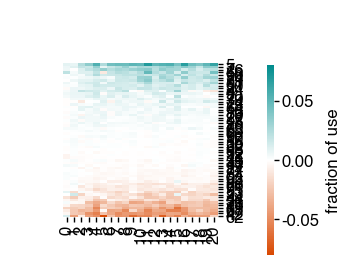

In [11]:
cg=sns.clustermap(
    data=data,
    cmap=cmmf, 
    figsize=(1.3, 1.3),
    #col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=keep_syllables[ind],
    xticklabels=True,
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.08,
    vmin=-0.08,
)

In [12]:
data

array([[ 0.00816483,  0.00746283,  0.02322688, ...,  0.04022964,
         0.05011903,  0.06363531],
       [ 0.00619314,  0.00984104,  0.01908084, ...,  0.01726785,
         0.03569408,  0.03422041],
       [ 0.00539619, -0.00045439,  0.01107695, ...,  0.01224425,
         0.01999542,  0.02168404],
       ...,
       [-0.00844307, -0.02331785, -0.03240171, ..., -0.01868778,
        -0.0296533 , -0.03598114],
       [-0.00402095, -0.02317   , -0.02742342, ..., -0.03014255,
        -0.03465857, -0.04232861],
       [ 0.01224264, -0.04165162, -0.00823   , ..., -0.04272657,
        -0.04194012, -0.01911616]])

<Axes: >

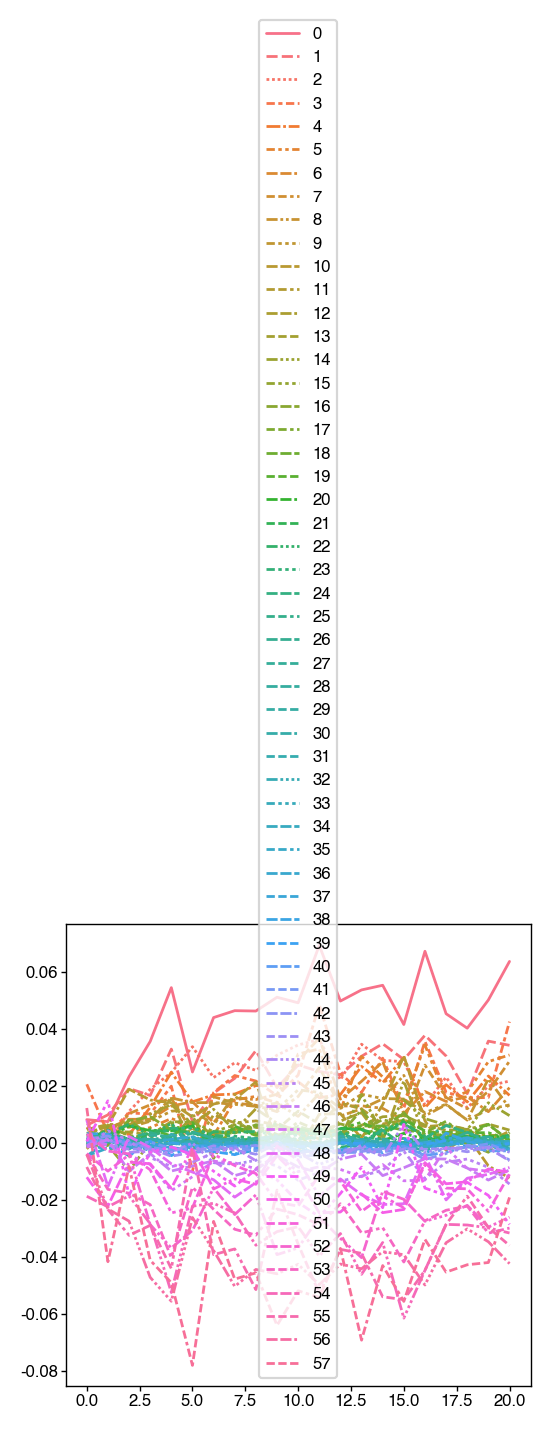

In [14]:
sns.lineplot(data.T)

In [21]:
format_plots()

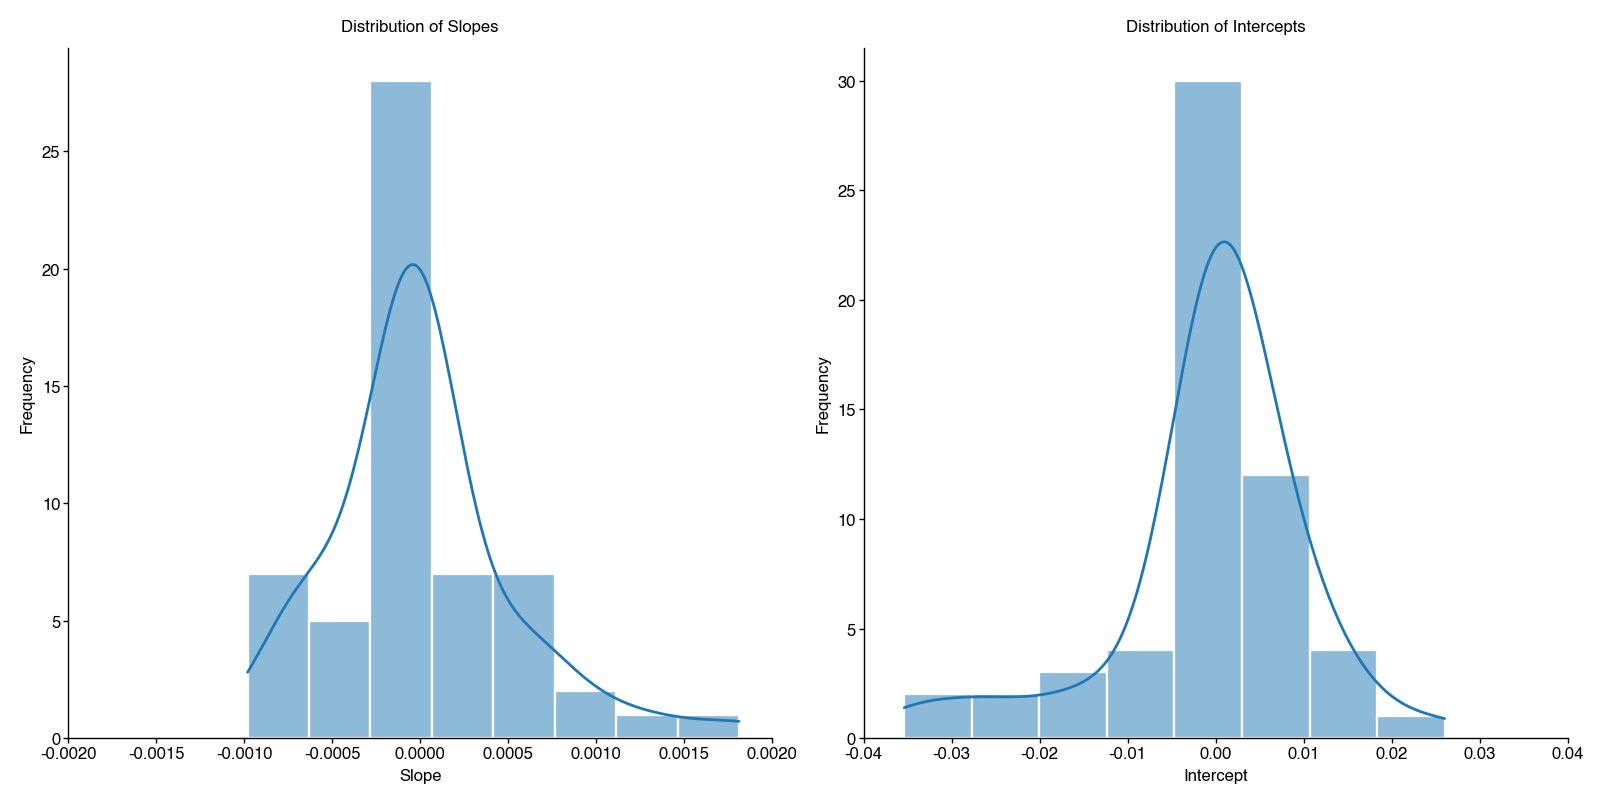

In [30]:
from scipy.stats import linregress
# Initialize lists to store slopes and intercepts
slopes = []
intercepts = []
bins=8

# Perform linear regression for each variable
for i in range(data.shape[0]):
    y = data[i]
    x = np.arange(data.shape[1])
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes.append(slope)
    intercepts.append(intercept)

# Create a DataFrame for plotting
df = pd.DataFrame({'Slope': slopes, 'Intercept': intercepts})

# Plotting the distributions
plt.figure(figsize=(8, 4))

# Distribution of slopes
plt.subplot(1, 2, 1)
sns.histplot(df['Slope'], kde=True, bins=bins)
plt.title('Distribution of Slopes')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.xlim([-0.002, 0.002])

# Distribution of intercepts
plt.subplot(1, 2, 2)
sns.histplot(df['Intercept'], kde=True, bins=bins)
plt.title('Distribution of Intercepts')
plt.xlabel('Intercept')
plt.ylabel('Frequency')
plt.xlim([-0.04, 0.04])
sns.despine()
plt.tight_layout()
plt.show()

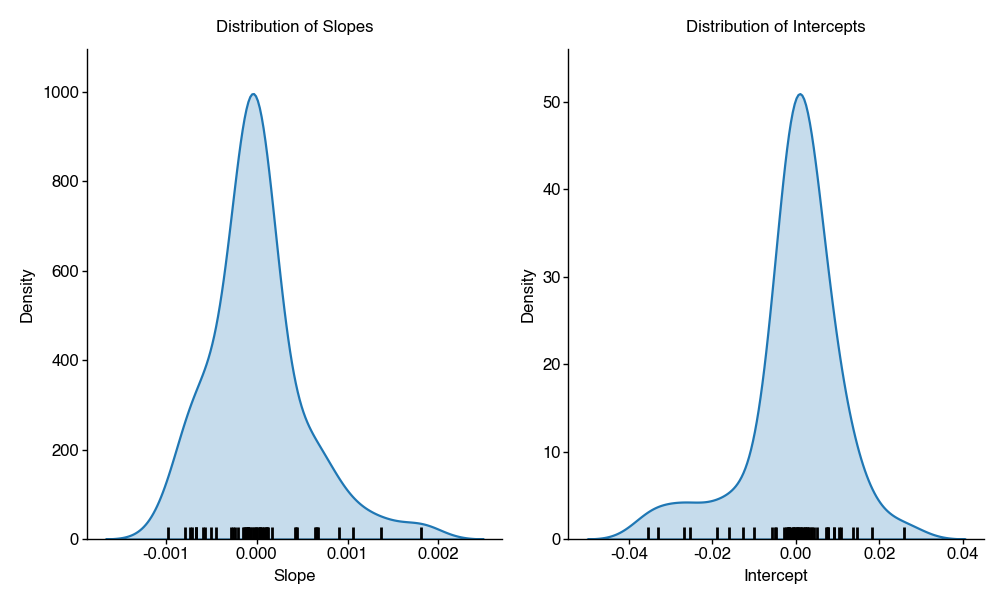

In [33]:
# Plotting the distributions
plt.figure(figsize=(5, 3))

# Distribution of slopes
plt.subplot(1, 2, 1)
sns.kdeplot(df['Slope'], fill=True)
sns.rugplot(df['Slope'], color='black')
plt.title('Distribution of Slopes')
plt.xlabel('Slope')
plt.ylabel('Density')

# Distribution of intercepts
plt.subplot(1, 2, 2)
sns.kdeplot(df['Intercept'], fill=True)
sns.rugplot(df['Intercept'], color='black')
plt.title('Distribution of Intercepts')
plt.xlabel('Intercept')
plt.ylabel('Density')
sns.despine()
plt.tight_layout()
plt.show()